In [1]:
import sys

sys.path.append("../src")

In [2]:
import warnings

import eda_functions as eda
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## Объявление констант и установок

In [3]:
warnings.filterwarnings("default")

In [4]:
pd.set_option("display.max_columns", None)

In [5]:
RANDOM_STATE = 1206

In [6]:
tqdm.pandas()

## Изучение и подготовка данных

### Загрузка и изучение данных 

Исходные данные представлены заказчиком в виде файла csv. Загрузим данные и отобразим их основные характеристики.

In [7]:
data = pd.read_csv("../data/data.csv")

In [8]:
# profile = ProfileReport(data, title="Profiling Report")
# profile.to_notebook_iframe()



Описание данных предоставлено заказчиком:
- **Age**: Age in years when a woman is pregnant. _Возраст в годах женщины во время беременности_.
- **SystolicBP**: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy. _Верхнее значение кровяного давления в мм рт.ст_.
- **DiastolicBP**: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy. _Нижнее значение кровяного давления в мм рт.ст_.
- **BS**: Blood glucose levels is in terms of a molar concentration, mmol/L. _Уровень глюкозы в крови в молярной концентрации, ммоль/л_.
- **HeartRate**: A normal resting heart rate in beats per minute. _Нормальная частота сердечных сокращений в ударах в минуту_.
- **RiskLevel**: Predicted Risk Intensity Level during pregnancy considering the previous attribute. _Предполагаемый уровень интенсивности риска во время беременности_.

**BodyTemp**: Описание отсутствует. По характеру данных можно предположить, что признак соответствует нормальной температуре тела пациента, выраженной в градусах фаренгейта.

### Вывод по разделу "Загрузка и изучение входных данных"

На основании общих сведений о входных данных таблицы `data` были сделаны следующие выводы о полноте и качестве данных для достижения целей исследования:

1. Данные содержат 7 признаков: 5 количественных (типы - int64 и float64) и 1 категориальный (тип object, в частности - string). Преобразование типов не требуется. При этом, изменение количественных типов цулесообразно для оптимизации работы, однако, данных не много, преобразовывать не будем.
2. Для удобства работы целесообразно изменить наименование признаков в snake case стиле.
3. Входных признаков 6: [`Age`, `SystolicBP`, `DiastolicBP`, `BodyTemp`, `BS`, `HeartRate`], целевой признак - `Risk Level`.
4. Предварительные гистограммы распределений количественных показывают необходимость анализа выбросов и аномальных знчений. При этом, обнаруженные с использованием диаграмм размаха "выбросы" следует оценить в соответствии с предметной областью.
5. Среди признаков пропусков не выявлено. При этом аномальное значение, близкое к 0, признака `HeartRate` может оказать фактическим пропуском. Необходимо его обработать.
6. Выявлены 304 дублирующихся записи. Необходима обработка дубликатов.
7. Среди целевого признака могут оказаться неявные дубликаты. Необходим дополнительный анализ.

### Преобработка данных 

Прозведем предобработку данных на основании ранее сделанных выводов:

1. Изменим наименования столбцов.
2. Обработаем выявленные дубликаты.
3. Проверим наличие неявных дубликатов и обработаем их при необходимости.
4. Изучим и обработаем возможные пропуски в данных. Примем решение о порядке работы с пропусками при работе с моделями МО.

Предварительно создадим копию входных данных для текущего этапа работы.

In [9]:
preprocessing_data = data.copy()

#### Обработка наименований столбцов

In [10]:
preprocessing_data = preprocessing_data.rename(
    columns={
        "Age": "age",
        "SystolicBP": "systolic_bp",
        "DiastolicBP": "diastolic_bp",
        "BS": "glucose_level",
        "BodyTemp": "body_temperature",
        "HeartRate": "heart_rate",
        "RiskLevel": "risk_level",
    }
)

In [11]:
preprocessing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1014 non-null   int64  
 1   systolic_bp       1014 non-null   int64  
 2   diastolic_bp      1014 non-null   int64  
 3   glucose_level     1014 non-null   float64
 4   body_temperature  1014 non-null   float64
 5   heart_rate        1014 non-null   int64  
 6   risk_level        1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


#### Обработка явных дубликатов

В ходе первичного ознакомления с данными было выявлено 304 дублирующихся записи. Оценим, сколько всего дубликатов, сохранив по 1 экземпляру.

In [12]:
preprocessing_data.duplicated(keep="first").sum()

562

Для 304 записей имеется 562 дублирующих их записи. Отобразим некоторые дубликаты.

In [13]:
preprocessing_data[preprocessing_data.duplicated()].head()

,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate,risk_level
67,19,120,80,7.0,98.0,70,mid risk
72,19,120,80,7.0,98.0,70,mid risk
97,19,120,80,7.0,98.0,70,mid risk
106,50,140,90,15.0,98.0,90,high risk
107,25,140,100,6.8,98.0,80,high risk


Дубликаты при создании моделей МО целесообразно удалить. К сожалению, при этом теряется очень много информации.

In [14]:
preprocessing_data = preprocessing_data.drop_duplicates(keep="first")

Проверим остаток данных

In [15]:
preprocessing_data.shape

(452, 7)

In [16]:
f"{preprocessing_data.shape[0]/data.shape[0] * 100:.2f}%"

'44.58%'

Потеряно около 55% данных.

#### Обработка неявных дубликатов

Проверим наличие дубликатов без учета целевого признака. Поскольку возможны случаи предположения разного уровня риска для одинаковых показателей здоровья.

In [17]:
preprocessing_data.drop("risk_level", axis=1).duplicated().sum()

36

Верно, осталось еще 36 дубликатов, отобразим их.

In [18]:
preprocessing_data[
    preprocessing_data.duplicated(
        subset=[
            "age",
            "systolic_bp",
            "diastolic_bp",
            "glucose_level",
            "body_temperature",
            "heart_rate",
        ],
        keep=False,
    )
].sort_values(by="age").head(15)

,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate,risk_level
543,12,90,60,7.5,102.0,66,low risk
251,12,95,60,6.9,98.0,65,low risk
588,12,90,60,7.5,102.0,66,mid risk
82,12,95,60,6.9,98.0,65,mid risk
561,13,90,65,7.5,101.0,80,low risk
610,13,90,65,7.5,101.0,80,high risk
531,15,120,80,7.5,98.0,70,mid risk
579,15,120,80,7.5,98.0,70,low risk
260,16,100,70,6.9,98.0,80,low risk
87,16,100,70,6.9,98.0,80,mid risk


К сожалению, между двумя одинаковыми записями с разным целевым признаком, выбрать запись с верным целевым признаком сложно. В связи с тем, что данных для обучения модели МО уже осталось мало, целесообразно неопределенности удалить.
В то же время, имеется шанс оценить правильный целевой признак на основании метода ближайших соседей. Рассмотрим данный способ увеличения количества данных с целью повышения качества моделей после основного этапа моделирования.

In [19]:
preprocessing_data = preprocessing_data.drop_duplicates(
    subset=[
        "age",
        "systolic_bp",
        "diastolic_bp",
        "glucose_level",
        "body_temperature",
        "heart_rate",
    ],
    keep=False,
)

Проверим остаток данных

In [20]:
preprocessing_data.shape

(381, 7)

In [21]:
f"{preprocessing_data.shape[0]/data.shape[0] * 100:.2f}%"

'37.57%'

Потеряно около 73% данных.

Проверим на наличие неявных дубликатов целевой признак, выраженный строкой.

In [22]:
preprocessing_data["risk_level"].unique()

array(['high risk', 'mid risk', 'low risk'], dtype=object)

Дубликатов не выявлено.

#### Обработка пропусков

Среди признаков при первичном ознакомлении с данными пропусков не было выявлено. При этом аномальное значение, близкое к 0, признака HeartRate может оказать фактическим пропуском. Необходимо его обработать.

In [23]:
preprocessing_data["heart_rate"].describe()

count    381.000000
mean      73.771654
std        8.265835
min        7.000000
25%       70.000000
50%       76.000000
75%       80.000000
max       90.000000
Name: heart_rate, dtype: float64

Минимальное значение - 7. Вероятно, это не пропуск, а ошибка. Логично предположить, что в данных пропущена вторая цифра после 7, которая отнесет аномальное значение в разряд средних. При этом уточним, имеются ли также малые значения.

In [24]:
preprocessing_data.sort_values(by="heart_rate").head(5)

,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate,risk_level
499,16,120,75,7.9,98.0,7,low risk
306,12,120,95,6.9,98.0,60,low risk
53,19,120,85,7.0,98.0,60,low risk
93,23,120,90,7.8,98.0,60,mid risk
98,19,120,85,7.8,98.0,60,mid risk


Данное значение единственное. Заменим его средним значением, чтобы не терять драгоценные данные.

In [25]:
preprocessing_data.loc[preprocessing_data["heart_rate"] == 7, "heart_rate"] = int(
    preprocessing_data["heart_rate"].mean()
)

### Вывод по разделу "Преобработка данных"

Прозведем предобработку данных на основании ранее сделанных выводов:

1. Изменим наименования столбцов.
2. Обработаем выявленные дубликаты.
3. Проверим наличие неявных дубликатов и обработаем их при необходимости.
4. Изучим и обработаем возможные пропуски в данных. Примем решение о порядке работы с пропусками при работе с моделями МО.

В ходе предобработки данных были достигнуты следующие результаты:

1. Изменены наименования столбцов в стиле snake_case.
2. Были обнаружены 304 дублирующихся записи. Количество полных дубликатов составило 562. Дубликаты были удалены.
3. Кроме того, были обнаружены 36 неявных дубликатов, связанных с указанием разного целевого признака для идентичных записей. К сожалению, между двумя одинаковыми записями с разным целевым признаком, выбрать запись с верным целевым признаком сложно. В связи с тем, что данных для обучения модели МО уже осталось мало, неопределенность была исключена из данных. В то же время, имеется шанс оценить правильный целевой признак на основании метода ближайших соседей. Рассмотрим данный способ увеличения количества данных с целью повышения качества моделей после основного этапа моделирования.
4. Изучены аномальные значения признака HeartRate близкие к 0. Такое значение, равное 7, оказалось одно. Обработано заменой на среднее значение, поскольку логично предположить, что в данных пропущена вторая цифра после 7, которая отнесет аномальное значение в разряд средних (порядок совпадает). 

Предобработка данных завершена, данные готовы к дальнейшей очистки и анализу.

## Исследовательский анализ данных 

Проведем исследовательский анализ данных. В ходе анализа постараемся оценить:
1. Распределение категориальных признаков. В нашем случае - целевого признака.
2. Распределение количественных признаков, в том числе, тип распределений, влияющих на дальнейшую работу по разработке моделей МО, наличие и природу выбросов и аномальных значений.

Предварительно создадим копию данных для текущего этапа работы.

In [26]:
eda_data = preprocessing_data.reset_index(drop=True).copy()

In [27]:
eda_data.head()

,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate,risk_level
0,25,130,80,15.00,98.0,86,high risk
1,35,140,90,13.00,98.0,70,high risk
2,29,90,70,8.00,100.0,80,high risk
3,30,140,85,7.00,98.0,70,high risk
4,23,140,80,7.01,98.0,70,high risk


In [28]:
eda_data.tail()

,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate,risk_level
376,12,100,50,6.4,98.0,70,mid risk
377,15,100,60,6.0,98.0,80,low risk
378,15,100,49,7.6,98.0,77,low risk
379,12,100,50,6.0,98.0,70,mid risk
380,21,100,50,6.8,98.0,60,low risk


В случае генерации новых признаков с целью удобства дальнейшей работы определим исходные признаки и генерируемые.

In [29]:
original_cat_features = list(
    eda_data.drop("risk_level", axis=1).select_dtypes(include="O")
)
original_cat_features

[]

In [30]:
original_num_features = list(eda_data.select_dtypes(include="number"))
original_num_features

['age',
 'systolic_bp',
 'diastolic_bp',
 'glucose_level',
 'body_temperature',
 'heart_rate']

In [31]:
new_num_features, new_cat_features = [], []

In [32]:
target = "risk_level"

**I. Для столбца с категориальным признаком - целевым признаком `risk_level`**
1. Построим круговую диаграмму.
2. Оценим баланс классов признака. Определим необходимость балансировки классов.

Для выполнения работ в соответствии с описанным подходом будем использовать созданные ранее функции.

**II. Для каждого столбца с количественным параметром:**
1. Определим количественные характеристики распределений значений, построим гистрограммы и диаграммы размаха.
2. Определим выбросы. При необходимости более внимательно изучим выбросы в части их влияния на цель исследования и примем решение об их исправлении или удалении.<br>Основным критерием удаления выбросов определим их выход за пределы диаграммы размаха. При количестве строк с аномальными значениями менее 5% выборки, такие строки приоритетны к удалению, но может потребоваться дополнительный анализ.<br>При количестве выбросов более 5% их удаление производить не будем до исследования других параметров. Создадим запрос для использования метода query() в будущем с целью фильтрации данных.
3. После очистки данных изучим их распределение, визуализируем. Сделаем выводы.
4. Проверим нормальность распределения значений столбца.

Исследуемые столбцы с количественным параметром:
- `age`;
- `systolic_bp`;
- `diastolic_bp`;
- `glucose_level`;
- `body_temperature`;
- `heart_rate`.

Для выполнения работ будем использовать созданные функции, выводящие результаты анализа для категориальных признаков в соответствии с описанным выше подходом

### I. Исследование категориальных признаков

c:\Users\filat\Documents\projects\maternal_health_risk\.venv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


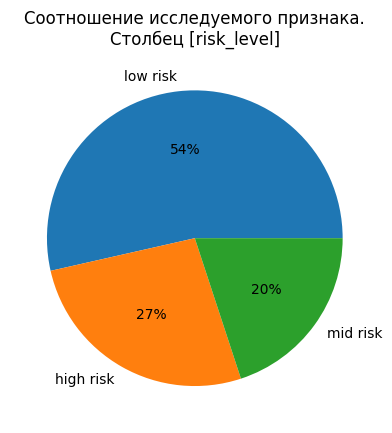

In [33]:
eda.analysis_cat_cols(eda_data, [target])

**Промежуточный вывод**

Для категориального целевого признаков выявлено:
1. Незначительный дисбаланс классов, который не должен оказать влияния на обучение моделей МО. При этом, будем использовать параметр class_weight='balanced' в алгоритмах, которые могут его учесть.
2. В дальнейшей работе необходимо провести кодирование категориального целевого признака с использованием LabelEncoder.

### II. Изучение столбцов с количественными признаками

**II. Для каждого столбца с количественным параметром:**
1. Определим количественные характеристики распределений значений, построим гистрограммы и диаграммы размаха.
2. Определим выбросы. При необходимости более внимательно изучим выбросы в части их влияния на цель исследования и примем решение об их исправлении или удалении.<br>Основным критерием удаления выбросов определим их выход за пределы диаграммы размаха. При количестве строк с аномальными значениями менее 5% выборки, такие строки приоритетны к удалению, но может потребоваться дополнительный анализ.<br>При количестве выбросов более 5% их удаление производить не будем до исследования других параметров. Создадим запрос для использования метода query() в будущем с целью фильтрации данных.
3. После очистки данных изучим их распределение, визуализируем. Сделаем выводы.
4. Проверим нормальность распределения значений столбца.

Исследуемые столбцы с количественным параметром:
- `age`;
- `systolic_bp`;
- `diastolic_bp`;
- `glucose_level`;
- `body_temperature`;
- `heart_rate`.

Для выполнения работ будем использовать созданные функции, выводящие результаты анализа для категориальных признаков в соответствии с описанным выше подходом

**Столбец `age`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции для всех таблиц.

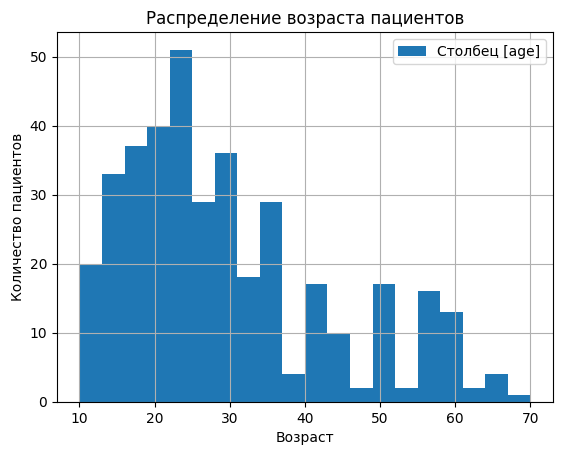


Ключевые характеристики распределения:
count    381.00
mean      29.24
std       13.75
min       10.00
25%       19.00
50%       25.00
75%       35.00
max       70.00
Name: age, dtype: object

Ключевые характеристики диаграммы размаха:
IQR			16.00
Q1-1,5*IQR		-5.00
MIN диаграммы размаха	10.00
Q3+1,5*IQR		59.00
MAX диаграммы размаха	59.00



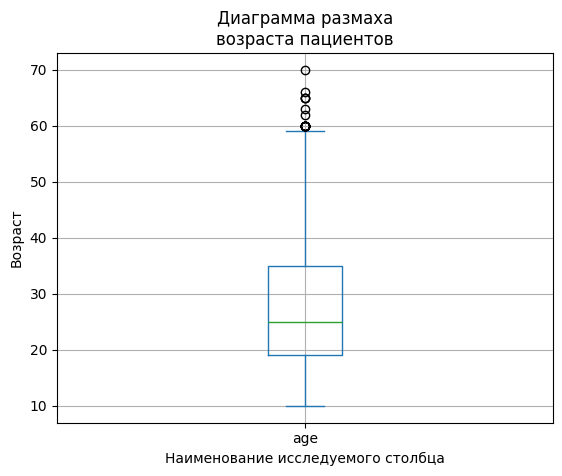

Ключевые характеристики выбросов:
Количество выбросов (вверх)	19
Доля выбросов (вверх)		4.99%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [34]:
eda.describe_numcols(
    eda_data,
    "age",
    hist_desc=("Распределение возраста пациентов", "Возраст", "Количество пациентов"),
    box_desc=(
        "Диаграмма размаха\nвозраста пациентов",
        "Наименование исследуемого столбца",
        "Возраст",
    ),
)

На диаграмме размаха выявлены статистические выбросы вверх. Это возраст пациентов более 59 лет. Данные значения не могут являться выбросами, но очень похожи на аномалии в зависимости от их целевого признака. Отобразим эти записи.

In [35]:
eda_data.query("age >= 59")

,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate,risk_level
32,60,120,80,6.1,98.0,75,low risk
50,60,90,65,7.0,98.0,77,low risk
82,60,90,65,6.8,98.0,77,mid risk
95,63,140,90,15.0,98.0,90,high risk
169,60,120,80,7.7,98.0,75,low risk
193,60,90,65,6.9,98.0,77,low risk
197,62,120,80,6.9,98.0,66,low risk
205,65,90,60,6.9,98.0,70,low risk
206,60,120,80,6.9,98.0,76,low risk
209,66,85,60,6.9,98.0,86,low risk


Если бы целевой признак для всех таких записей был 'high risk', то записи можно было бы признать нормальными на основании жизненного опыта. При этом, удалять их без консультации со специалистов - нецелесообразно. Возникает сомнение в правильности разметки данных. Можно предположить, что возраст - один из основных факторов влияющих на риск для здоровья беременной, и при значениях больше 60 этот риск - высокий.

Оставим без изменений.

Визуализируем распределение

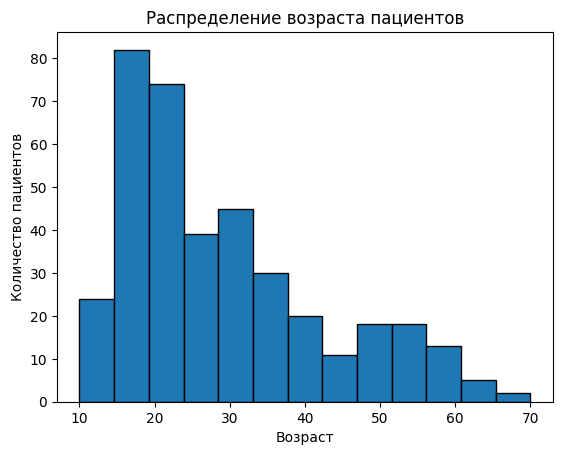

In [36]:
plt.hist(eda_data["age"], edgecolor="black", bins=13)
plt.title("Распределение возраста пациентов")
plt.xlabel("Возраст")
plt.ylabel("Количество пациентов")
plt.show()

**Промежуточный вывод**

Выявлены ключевые характеристики распределения возраста пациентов:

* среднее и медиана близки - 29.24 и 25 лет;
* возраст 50% пациентов в диапазоне от 19 до 35 лет;
* минимальное значение - 10 лет, максимальное - 70 лет.
  
Распределение возраста пациентов визуально представляет распределение Пуассона.

Среди записей обнаружены статистические выбросы, соответствующие пациентам старше 59 лет. Данные значения не могут являться выбросами, но очень похожи на аномалии в зависимости от их целевого признака. Для таких записей целевой признак оказался и 'low' и 'mid' и 'high' риск. При этом, логично предположить, что возраст - один из основных факторов влияющих на риск для здоровья беременной, и при значениях больше 60 этот риск - высокий.

Кроме того, в соответствии с рядом материалов ([High-risk_pregnancy](https://en.wikipedia.org/wiki/High-risk_pregnancy), [Teenage_pregnancy](https://en.wikipedia.org/wiki/Teenage_pregnancy))повышенный риск для здоровья беременной может наблюдаться при ее возрасте до 19 лет и после 35 лет. Целесообразно проконсультироваться со специалистами для уточнения указанных порогов и использования источников, заслуживающих профессионального доверия.

В связи с этим, предлагается следующее:
1. Не удалять существующие значения, которые представляются аномальными, без консультации со специалистами.
2. Создать новый категориальный признак, отражающий группу риска беременной по возрасту на основании данных Википедии. Целесообразно получить дополнительную консультацию и дополнительные источники данных.

In [37]:
def get_age_group(age):
    if age < 20:
        return "younger age"
    elif age > 35:
        return "older age"
    else:
        return "medium age"

In [38]:
eda_data["age_group"] = eda_data["age"].progress_apply(get_age_group)

100%|██████████| 381/381 [00:00<00:00, 380030.87it/s]


In [39]:
new_cat_features += ["age_group"]

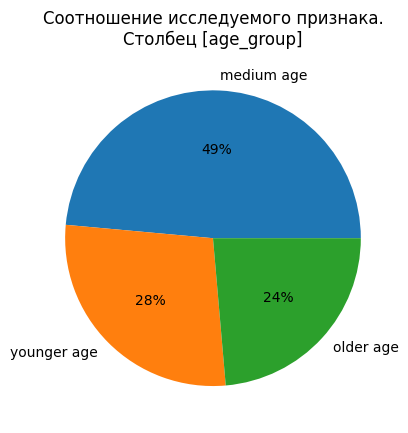

In [40]:
eda.analysis_cat_cols(eda_data, ["age_group"])

**Промежуточный вывод**

Созданный признак, фактически, имеет сбалансированное распределение, где 'medium age' - это низкий риск для здоровья беременной, а 'younger age' и 'older age' - высокий риск.

**Столбец `systolic_bp`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции для всех таблиц.

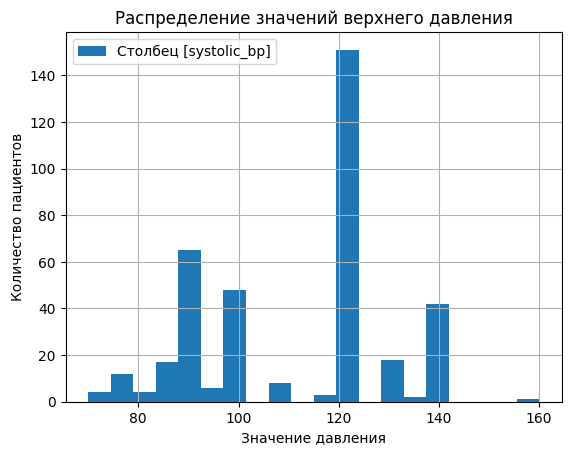


Ключевые характеристики распределения:
count    381.00
mean     110.68
std       18.53
min       70.00
25%       90.00
50%      120.00
75%      120.00
max      160.00
Name: systolic_bp, dtype: object

Ключевые характеристики диаграммы размаха:
IQR			30.00
Q1-1,5*IQR		45.00
MIN диаграммы размаха	70.00
Q3+1,5*IQR		165.00
MAX диаграммы размаха	160.00



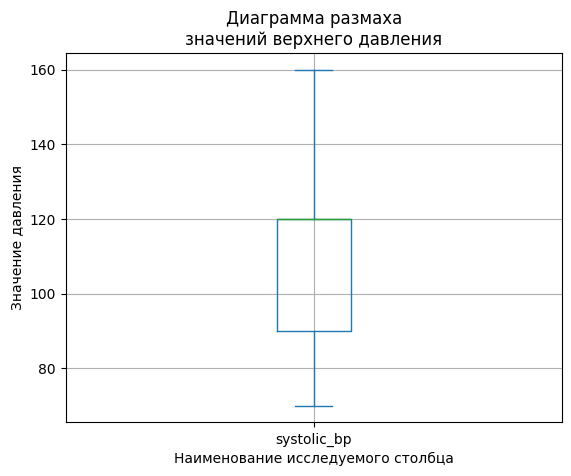

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [41]:
eda.describe_numcols(
    eda_data,
    "systolic_bp",
    hist_desc=(
        "Распределение значений верхнего давления",
        "Значение давления",
        "Количество пациентов",
    ),
    box_desc=(
        "Диаграмма размаха\nзначений верхнего давления",
        "Наименование исследуемого столбца",
        "Значение давления",
    ),
)

Оценим дискретность признака - количество уникальных значений.

In [42]:
eda_data["systolic_bp"].nunique()

19

Можно перевести признак в разряд категориальных, однако, в будущем при работе модели МО могут поступить данные, переводящие признак в непрерывный. Учтем этот случай и оставим признак количественным.

Визуализируем распределение

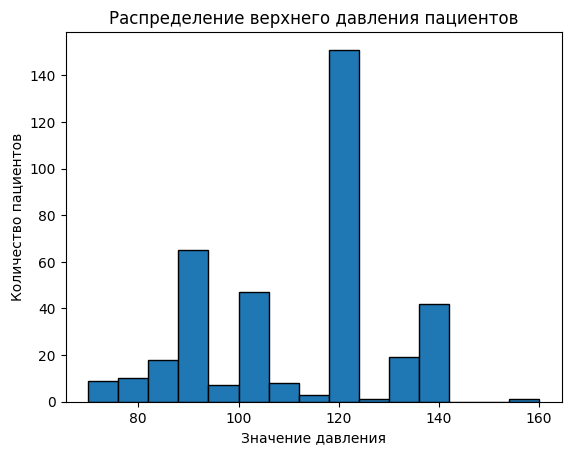

In [43]:
plt.hist(eda_data["systolic_bp"], edgecolor="black", bins=15)
plt.title("Распределение верхнего давления пациентов")
plt.xlabel("Значение давления")
plt.ylabel("Количество пациентов")
plt.show()

**Промежуточный вывод**

Выявлены ключевые характеристики распределения верхнего давления пациентов:

* среднее и медиана близки - 110.68 и 120.00;
* давление 50% пациентов в диапазоне от 90 до 120;
* минимальное значение - 70, максимальное - 160.
  
Распределение значений верхнего давления визуально не удается отнести к типовым распределениям. Выбросы не обнаружены.

Кроме того, в соответствии с материалами [High-risk_pregnancy](https://en.wikipedia.org/wiki/Blood_pressure#Auscultatory), можно также выделить группы пациентов в зависмости от значения верхнего и нижнего давления. В связи с этим, предлагается на основе признаков 'systolic_bp' и 'diastolic_bp'.

**Столбец `diastolic_bp`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции для всех таблиц.

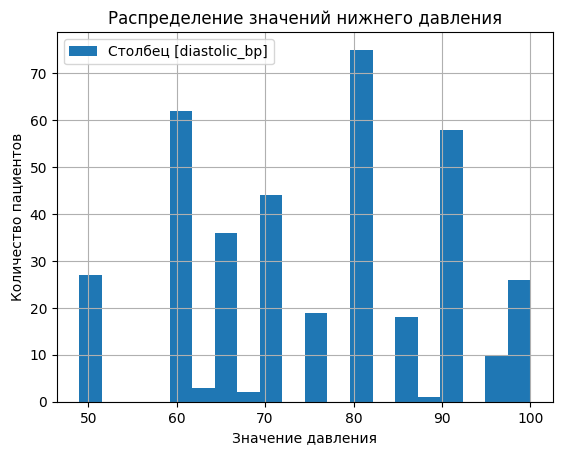


Ключевые характеристики распределения:
count    381.00
mean      75.12
std       13.94
min       49.00
25%       65.00
50%       75.00
75%       85.00
max      100.00
Name: diastolic_bp, dtype: object

Ключевые характеристики диаграммы размаха:
IQR			20.00
Q1-1,5*IQR		35.00
MIN диаграммы размаха	49.00
Q3+1,5*IQR		115.00
MAX диаграммы размаха	100.00



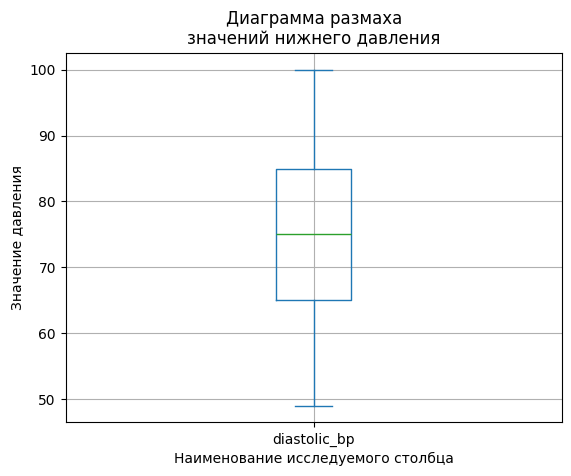

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [44]:
eda.describe_numcols(
    eda_data,
    "diastolic_bp",
    hist_desc=(
        "Распределение значений нижнего давления",
        "Значение давления",
        "Количество пациентов",
    ),
    box_desc=(
        "Диаграмма размаха\nзначений нижнего давления",
        "Наименование исследуемого столбца",
        "Значение давления",
    ),
)

Оценим дискретность признака - количество уникальных значений.

In [45]:
eda_data["diastolic_bp"].nunique()

16

Можно перевести признак в разряд категориальных, однако, в будущем при работе модели МО могут поступить данные, переводящие признак в непрерывный. Учтем этот случай и оставим признак количественным.

Визуализируем распределение

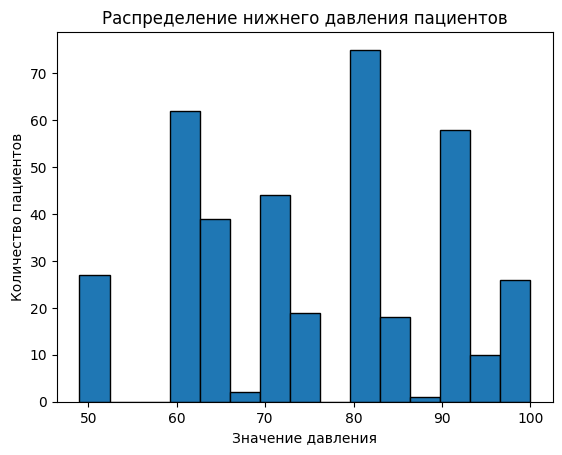

In [46]:
plt.hist(eda_data["diastolic_bp"], edgecolor="black", bins=15)
plt.title("Распределение нижнего давления пациентов")
plt.xlabel("Значение давления")
plt.ylabel("Количество пациентов")
plt.show()

**Промежуточный вывод**

Выявлены ключевые характеристики распределения нижнего давления пациентов:

* среднее и медиана близки - 75.12 и 75.00;
* давление 50% пациентов в диапазоне от 65.00 до 85.00;
* минимальное значение - 49.00, максимальное - 100.00.
  
Распределение значений нижнего визуально не удается отнести к типовым распределенияму. Выбросы не обнаружены.

На основании ранее сделанных выводов, сгенерируем новый категориальный признак.

In [47]:
def get_pressure_group(row):
    low_bp = row["diastolic_bp"]
    high_bp = row["systolic_bp"]
    if high_bp < 110 or low_bp < 70:
        return "hypotension"
    elif (high_bp >= 110 and high_bp < 120) and (low_bp >= 70 and low_bp < 80):
        return "optimal"
    elif (high_bp >= 110 and high_bp < 130) or (low_bp >= 70 and low_bp < 85):
        return "normal"
    elif (high_bp >= 130 and high_bp < 139) or (low_bp >= 85 and low_bp < 89):
        return "high_normal"
    elif (high_bp >= 140 and high_bp < 159) or (low_bp >= 90 and low_bp < 99):
        return "hypertension_stage_1"
    elif (high_bp >= 160 and high_bp < 179) or (low_bp >= 100 and low_bp < 109):
        return "hypertension_stage_2"
    elif high_bp >= 180 or low_bp >= 110:
        return "hypertension_stage_3"

In [48]:
eda_data["pressure_group"] = eda_data.progress_apply(get_pressure_group, axis=1)

100%|██████████| 381/381 [00:00<00:00, 95228.52it/s]


In [49]:
new_cat_features += ["pressure_group"]

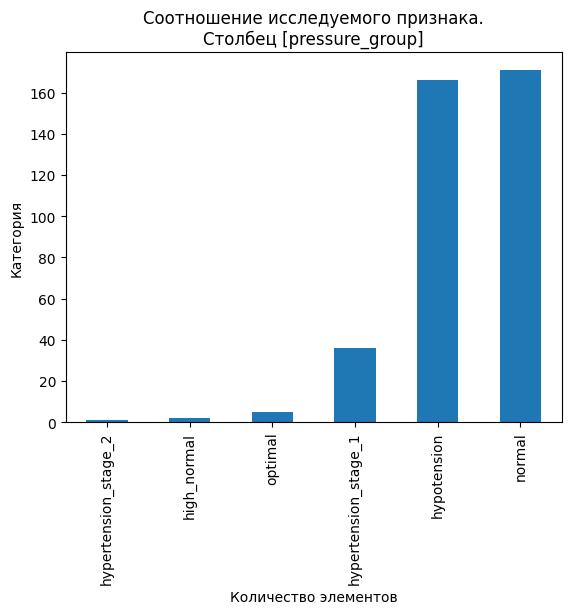

In [50]:
eda.analysis_cat_cols(eda_data, ["pressure_group"])

In [51]:
eda_data.sample(5)

,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate,risk_level,age_group,pressure_group
37,23,120,90,6.1,98.0,60,low risk,medium age,normal
28,22,120,90,7.1,98.0,82,low risk,medium age,normal
42,42,120,80,7.5,98.0,70,low risk,older age,normal
266,35,140,80,13.0,98.0,70,high risk,medium age,normal
186,40,120,75,7.7,98.0,70,high risk,older age,normal


**Промежуточный вывод**

Созданный признак, фактически, включает большую часть пациентов с нормальным давлением и гипотонией. Оставим так, как получилось, однако, границы значений давления весьма размыты. Также требуется консультация специалистов для уточнения групп пациентов.

**Столбец `glucose_level`**

В рассматриваемом столбце представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции для всех таблиц.

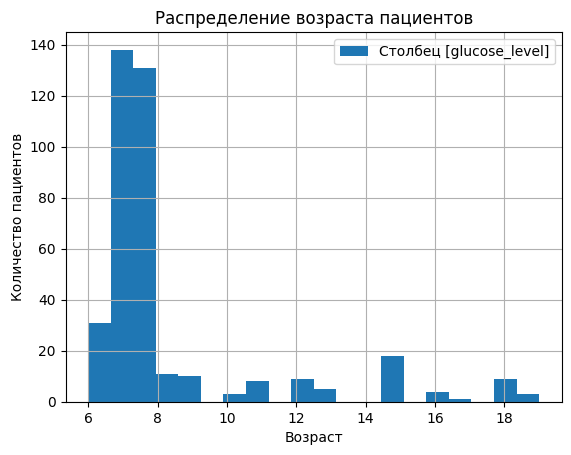


Ключевые характеристики распределения:
count    381.00
mean       8.37
std        2.85
min        6.00
25%        6.90
50%        7.50
75%        7.90
max       19.00
Name: glucose_level, dtype: object

Ключевые характеристики диаграммы размаха:
IQR			1.00
Q1-1,5*IQR		5.40
MIN диаграммы размаха	6.00
Q3+1,5*IQR		9.40
MAX диаграммы размаха	9.40



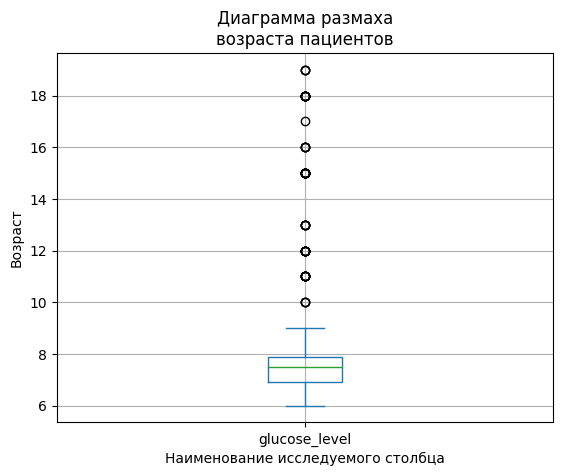

Ключевые характеристики выбросов:
Количество выбросов (вверх)	60
Доля выбросов (вверх)		15.75%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [52]:
eda.describe_numcols(
    eda_data,
    "glucose_level",
    hist_desc=("Распределение возраста пациентов", "Возраст", "Количество пациентов"),
    box_desc=(
        "Диаграмма размаха\nвозраста пациентов",
        "Наименование исследуемого столбца",
        "Возраст",
    ),
)

На диаграмме размаха выявлены статистические выбросы вверх. Отобразим записи с выбросами.

In [53]:
eda_data.query("glucose_level > 9.4").sort_values(by="glucose_level")

,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate,risk_level,age_group,pressure_group
348,28,95,60,10.0,101.0,86,high risk,medium age,hypotension
138,33,120,75,10.0,98.0,70,high risk,medium age,normal
267,29,90,70,10.0,98.0,80,high risk,medium age,hypotension
119,37,120,90,11.0,98.0,88,high risk,older age,normal
6,35,85,60,11.0,102.0,86,high risk,medium age,hypotension
345,29,90,70,11.0,100.0,80,high risk,medium age,hypotension
341,35,100,70,11.0,98.0,60,high risk,medium age,hypotension
147,17,90,60,11.0,101.0,78,high risk,younger age,hypotension
88,34,85,60,11.0,102.0,86,high risk,medium age,hypotension
167,12,90,60,11.0,102.0,60,high risk,younger age,hypotension


Выбросы не кажутся аномальными значениями. Оставим без изменений.

Визуализируем распределение

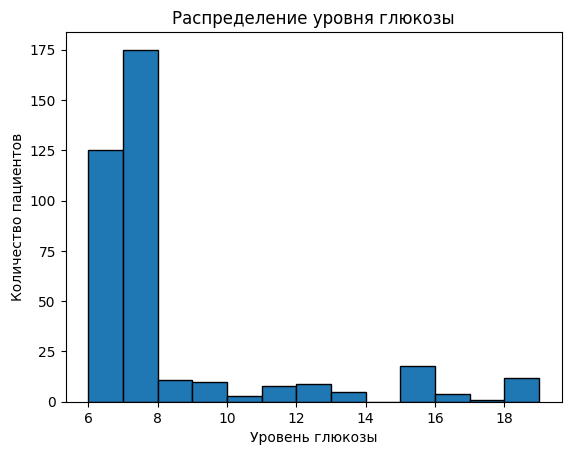

In [54]:
plt.hist(eda_data["glucose_level"], edgecolor="black", bins=13)
plt.title("Распределение уровня глюкозы")
plt.xlabel("Уровень глюкозы")
plt.ylabel("Количество пациентов")
plt.show()

**Промежуточный вывод**

Выявлены ключевые характеристики распределения уровня глюкозы пациентов:

* среднее и медиана близки - 8.37 и 7.50;
* уровень глюкозы 50% пациентов в диапазоне от 6.90 до 7.90;
* минимальное значение - 6.00, максимальное - 19.
  
Распределение уровня глюкозы визуально похоже на распределение Пуассона для дискретных количественных признаков. Фактически, разпределение уровня глюкозы может быть представлено, как распределение дискретного признака.

Дополнительных действий с признаков производить не будем.

**Столбец `body_temperature`**

В рассматриваемом столбце представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции для всех таблиц.

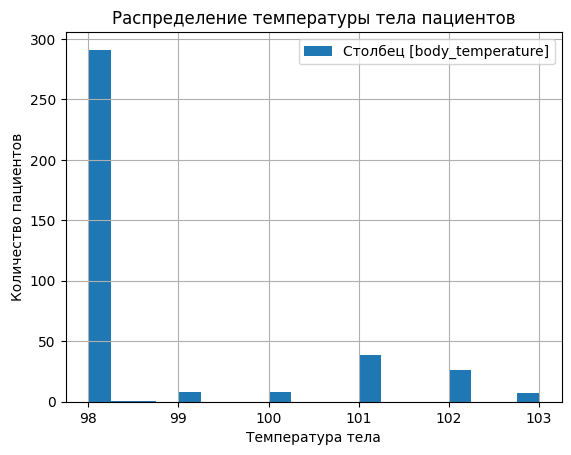


Ключевые характеристики распределения:
count    381.00
mean      98.74
std        1.43
min       98.00
25%       98.00
50%       98.00
75%       98.00
max      103.00
Name: body_temperature, dtype: object

Ключевые характеристики диаграммы размаха:
IQR			0.00
Q1-1,5*IQR		98.00
MIN диаграммы размаха	98.00
Q3+1,5*IQR		98.00
MAX диаграммы размаха	98.00



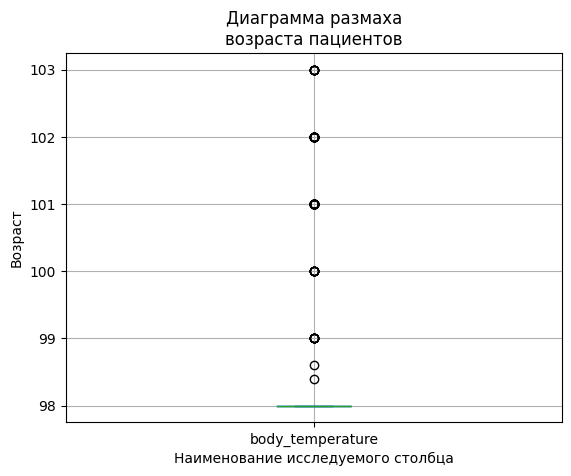

Ключевые характеристики выбросов:
Количество выбросов (вверх)	90
Доля выбросов (вверх)		23.62%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [55]:
eda.describe_numcols(
    eda_data,
    "body_temperature",
    hist_desc=(
        "Распределение температуры тела пациентов",
        "Температура тела",
        "Количество пациентов",
    ),
    box_desc=(
        "Диаграмма размаха\nвозраста пациентов",
        "Наименование исследуемого столбца",
        "Возраст",
    ),
)

На диаграмме размаха выявлены статистические выбросы вверх. Таковые значения могут являться аномалиями. Большое количество пациентов с температурой тела 101 градус Фаренгейта, что соответствует значению 38.3 градусам Цельсия. Такая температура считается повышенной температурой тела. Необходимо уточнить указанные значения у специалистов, собирающих данные. Отобразим записи с высокой температурой тела.

In [56]:
eda_data.query("body_temperature == 103").sort_values(by="body_temperature")

,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate,risk_level,age_group,pressure_group
134,17,90,65,6.1,103.0,67,high risk,younger age,hypotension
176,17,90,65,7.7,103.0,67,high risk,younger age,hypotension
214,45,120,80,6.9,103.0,70,low risk,older age,normal
216,65,120,90,6.9,103.0,76,low risk,older age,normal
219,22,120,80,6.9,103.0,76,low risk,medium age,normal
233,17,90,65,7.8,103.0,67,high risk,younger age,hypotension
259,17,140,100,6.8,103.0,80,high risk,younger age,hypertension_stage_1


In [57]:
eda_data.query("body_temperature == 102").sort_values(by="body_temperature")

,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate,risk_level,age_group,pressure_group
6,35,85,60,11.0,102.0,86,high risk,medium age,hypotension
314,17,85,60,7.5,102.0,86,low risk,younger age,hypotension
305,17,120,80,7.5,102.0,76,low risk,younger age,normal
301,18,120,80,7.9,102.0,76,mid risk,younger age,normal
295,17,85,60,7.9,102.0,86,low risk,younger age,hypotension
282,18,120,80,6.8,102.0,76,low risk,younger age,normal
261,36,140,100,6.8,102.0,76,high risk,older age,hypertension_stage_1
254,27,120,90,6.8,102.0,68,mid risk,medium age,normal
253,50,130,80,16.0,102.0,76,mid risk,older age,normal
237,17,85,69,7.8,102.0,86,high risk,younger age,hypotension


Возможно, указанные значения в данных появились в связи с оценкой характеристик пациента в момент реальной повышенной температуры. Предположительно, указанный признак можно исключить из обучения модели МО. В рамках моделирования, после анализа важности признаков, оценим качество моделей без этого признака.

Визуализируем распределение

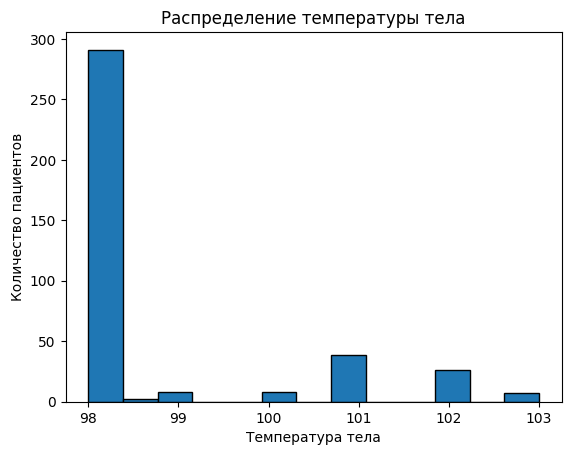

In [58]:
plt.hist(eda_data["body_temperature"], edgecolor="black", bins=13)
plt.title("Распределение температуры тела")
plt.xlabel("Температура тела")
plt.ylabel("Количество пациентов")
plt.show()

**Промежуточный вывод**

Выявлены ключевые характеристики распределения температуры тела пациентов:

* среднее и медиана близки - 98.74 и 98.00;
* температура тела 75% пациентов - 98.00;
* минимальное значение - 98.00, максимальное - 103.00.
  
Распределение температуры тела визуально не может быть отнесено к типовым распределениям непрерывных количественных признаков.

Дополнительных действий с признаков производить не будем.

**Столбец `heart_rate`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции для всех таблиц.

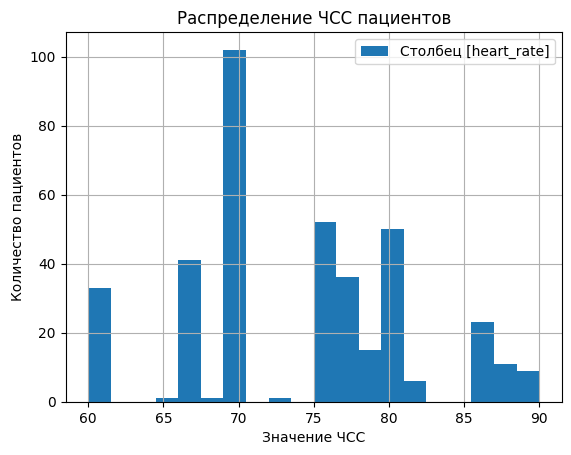


Ключевые характеристики распределения:
count    381.00
mean      73.94
std        7.52
min       60.00
25%       70.00
50%       76.00
75%       80.00
max       90.00
Name: heart_rate, dtype: object

Ключевые характеристики диаграммы размаха:
IQR			10.00
Q1-1,5*IQR		55.00
MIN диаграммы размаха	60.00
Q3+1,5*IQR		95.00
MAX диаграммы размаха	90.00



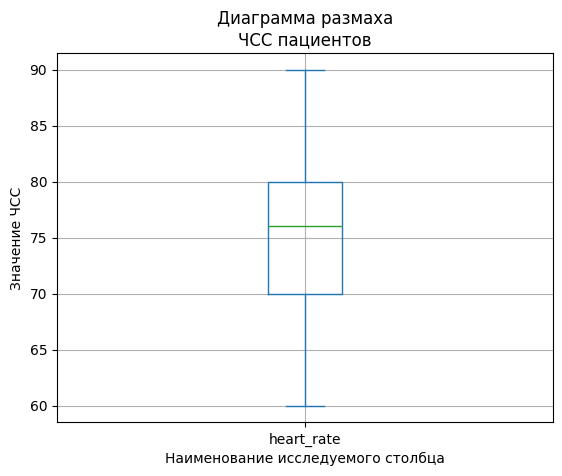

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [59]:
eda.describe_numcols(
    eda_data,
    "heart_rate",
    hist_desc=("Распределение ЧСС пациентов", "Значение ЧСС", "Количество пациентов"),
    box_desc=(
        "Диаграмма размаха\nЧСС пациентов",
        "Наименование исследуемого столбца",
        "Значение ЧСС",
    ),
)

Выбросов не обнаружено.

Визуализируем распределение

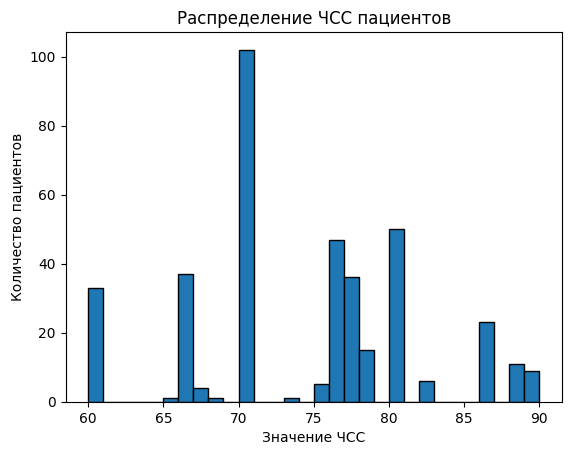

In [60]:
plt.hist(eda_data["heart_rate"], edgecolor="black", bins=30)
plt.title("Распределение ЧСС пациентов")
plt.xlabel("Значение ЧСС")
plt.ylabel("Количество пациентов")
plt.show()

**Промежуточный вывод**

Выявлены ключевые характеристики распределения частоты сердечных сокращений (ЧСС) пациентов:

* среднее и медиана близки - 73.94 и 76.00;
* ЧСС 50% пациентов в диапазоне от 70.00 до 80.00;
* минимальное значение - 60.00, максимальное - 90.00.
  
Распределение ЧСС пациентов визуально не может быть отнесено к типовым распределениям дискретных количественных признаков.

Дополнительных действий с признаков производить не будем.

Отобразим оригинальные и новые признаки

In [61]:
print(f"{original_cat_features=}\n")
print(f"{original_num_features=}\n")
print(f"{new_cat_features=}\n")
print(f"{new_num_features=}")

original_cat_features=[]

original_num_features=['age', 'systolic_bp', 'diastolic_bp', 'glucose_level', 'body_temperature', 'heart_rate']

new_cat_features=['age_group', 'pressure_group']

new_num_features=[]


In [62]:
cat_features = original_cat_features + new_cat_features
num_features = original_num_features + new_num_features

In [63]:
print(f"{cat_features=}\n")
print(f"{num_features=}")

cat_features=['age_group', 'pressure_group']

num_features=['age', 'systolic_bp', 'diastolic_bp', 'glucose_level', 'body_temperature', 'heart_rate']


Изучим результат работы.

In [64]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               381 non-null    int64  
 1   systolic_bp       381 non-null    int64  
 2   diastolic_bp      381 non-null    int64  
 3   glucose_level     381 non-null    float64
 4   body_temperature  381 non-null    float64
 5   heart_rate        381 non-null    int64  
 6   risk_level        381 non-null    object 
 7   age_group         381 non-null    object 
 8   pressure_group    381 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 26.9+ KB


### Вывод по разделу "Исследовательский анализ данных" 


В результате проведения исследовательского анализа были выявлены следующие факторы, влияющие на достижение цели работы.

**В части целевого признака:**
1. Целевой признак категориальный, включает в свой состав 3 категории риска для здоровья беременных: 'high risk', 'mid risk', 'low risk'.
2. Имеется незначительный дисбаланс классов, который не должен оказать влияния на обучение моделей МО. При этом, будем использовать параметр class_weight='balanced' в алгоритмах, которые могут его учесть.
3. В дальнейшей работе необходимо провести кодирование категориального целевого признака с использованием LabelEncoder.

**В части категориальных признаков:**

1. Оригинальных входных признаков не имеется. При этом, признаки 'body_temperature' и 'glucose_level' дискретны в достаточной степени, чтоы определить их категориальными. Однако, в будущем при работе модели входные данные по указанным признакам могут быть любыми (например, с учетом десятичных значений). В связи с этим, указанные признаки оставлены количественными.
2. В ходе анализа создано два категориальных признака на основании данных, обнаруженных в различных источниках:
    - 'age_group', отражающий группу риска беременной по возрасту;
    - 'pressure_group', отражающий группу беременной по артериальному давлению: гипотония, нормальное давление, гипертония.
3. Принято решение о видах кодирования новых многокатегориальных признаков:
    - с использованем OneHotEncoder для линейных моделей, поскольку признакам не следует придавать видимость ранговости;
    - с использованием OrdinalEncoder для моделей, не относящихся к линейным, посколько при их использовании не важны искусственные ранги категориальных признаков, а количество признаков не увеличивается, как при использовании OneHotEncoder.
    
**В части количественных признаков:**

1. Ключевые характеристики количественных признаков:
    - `age` - возраст 50% пациентов в диапазоне от 19 до 35 лет, что соответствует нормальной группе риска по возрасту. Минимальный возраст - 10 лет, максимальный - 70 лет. На основе признака создан новый категориальный признак.
    - `systolic_bp` и `diastolic_bp` - в целом, большая часть пациентов обладает нормальным давлением (120/70) и пониженным (ниже 110/70). Однако, границы пониженного давления весьма размыта. На основе признака создан новый категориальный признак.
    - `glucose_level` - медианное значение 7.50, что выше нормального, равного 6.00. Однако, минимальное значение - 6.00. Данные выглядят сомнительно. Необходимо оценить влияние признака на целевой признак. Оценим это в рамках корреляционного анализа и важности признаков в обучении моделей МО.
    - `body_temperature` - аналогично показателю уровня глюкозы в крови. Медианное значение 98.00 градусов Фаренгета, что соответствует нормальной температуре 36,6 градусов Цельсия. Такая температура представлена для большинства пациентов. Иные значения - выше нормальных. Предполагается, что признак может не оказывать влияния на целевой признак. Необходимо оценить влияние признака на целевой признак. Оценим это в рамках корреляционного анализа и важности признаков в обучении моделей МО.
    - `heart_rate` - медианное значение ЧСС пациентов - 76 ударов в минуту, что чуть выше среднего по популяции (70 ударов в минуту). При этом, 50% пациентов имеют показатель в диапазоне от 70 до 80 ударов в минуту. Предполагается, что признак может не оказывать влияния на целевой признак. Необходимо оценить влияние признака на целевой признак. Оценим это в рамках корреляционного анализа и важности признаков в обучении моделей МО.

3. Принято решение, что для корректного обучения моделей необходимо провести масштабирование количественных признаков в связи с большой разницей в масшатах. Для масштабирования предложен StandardScaler().

**Исследовательский анализ данных проведен, созданы новые признаки. Данные готовы к корреляционному анализу и отбору признаков для обучения**

## Корреляционный анализ данных

Построим матрицу корреляции с использованием библиотеки 'PhiK', поскольку целевой признак - категориальный. С использованием коэффициента корреляции Спирмена оценим наличие мультиколлинеарности количественных входных признаков (так как признаки распределены не нормально).

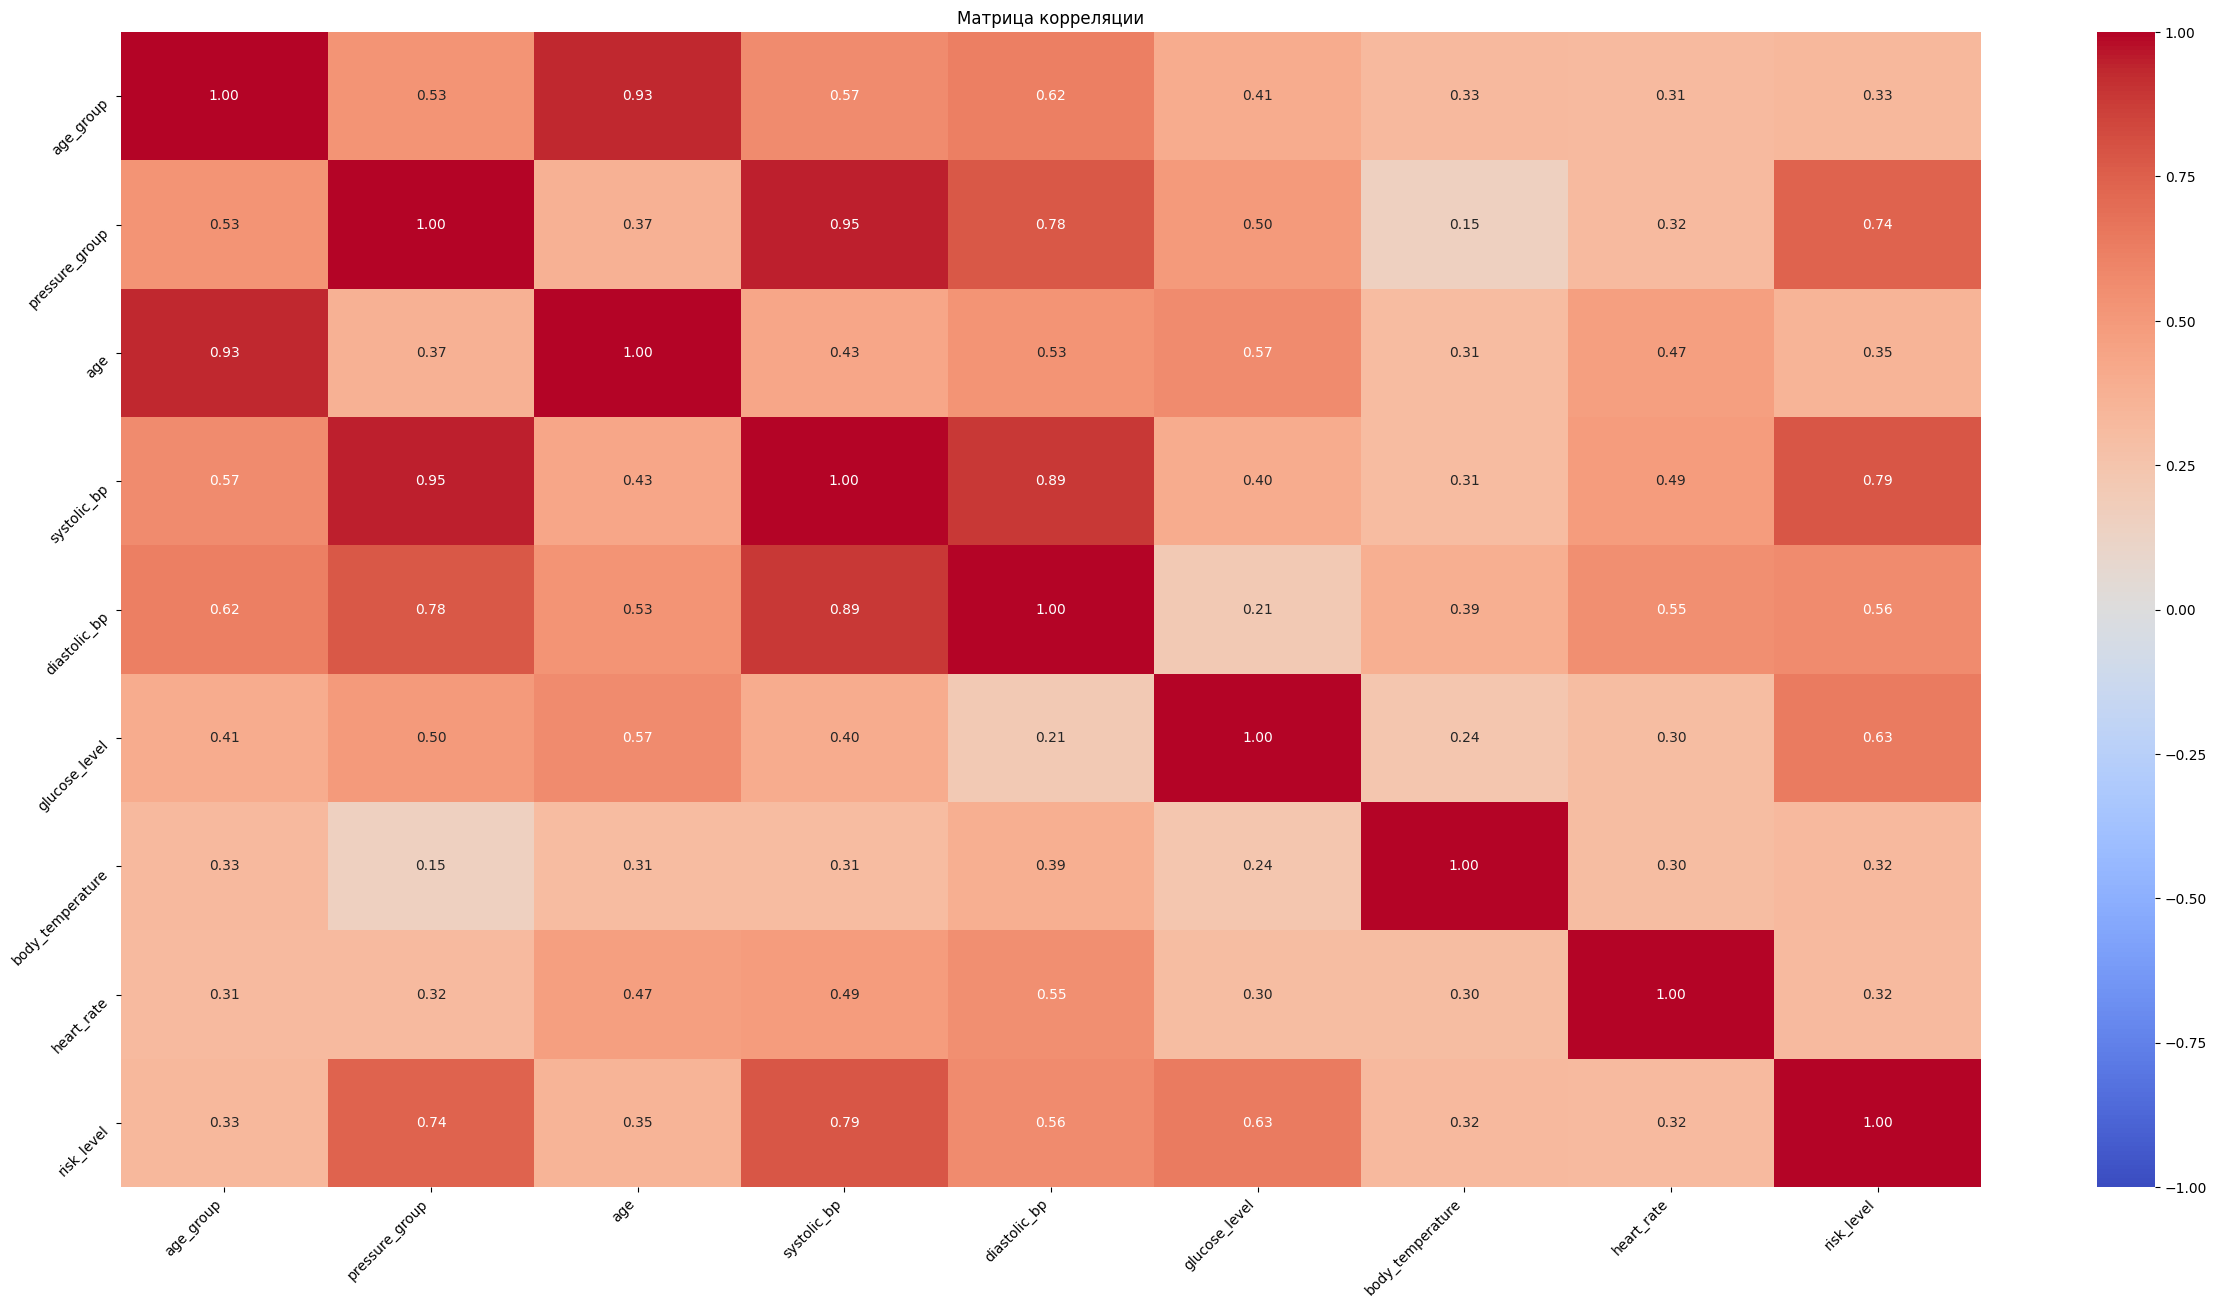

In [65]:
correlation = eda.corr_matrix(
    eda_data,
    cat_features + num_features,
    "phik",
    target=target,
    interval_cols=num_features,
)

На основании матрицы корреляции PhiK выявлено, что ряд признаков оказывает существенное влияние на целевой признак, в частности, `systolic_bp` (0.79), `diastolic_bp` (0.56) и `glucose_level` (0,63). Соответственно, новый признак `pressure_group` оказывает аналогичное влияние. Странно выглядит низкое влияние возраста `age` и нового признака `age_group`. Возникают сомнения в качестве разметки данных. Тем более, что указанные признаки влияют на целевой признак аналогично температуре тела (`body_temperature`) и ЧСС (`heart_rate').

Кроме того, ряд входных признаков взаимосязаны друг с другом. В частности, новые признаки `age_group` и `pressure_group` очевидно связаны с исходными признаками. Корреляция категориальных признаков, созданных на основа количественных близка к 1. Отметим, что Phik может выдать 1.0 при нелинейной зависимости, например, $X^2$.

Построим материцу корреляцию Спирмена для количественных признаков.

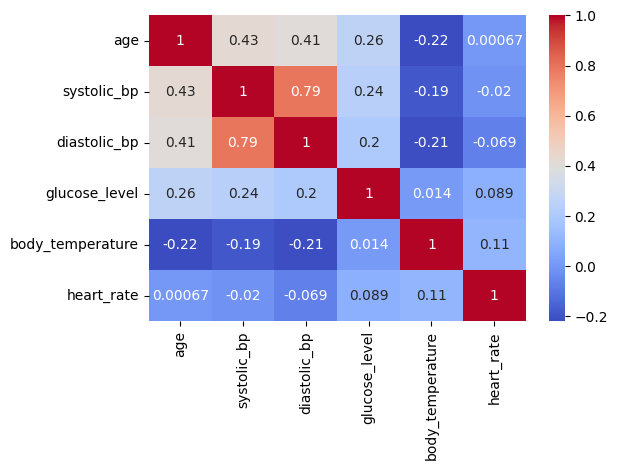

In [66]:
sns.heatmap(eda_data[num_features].corr(method="spearman"), annot=True, cmap="coolwarm")
plt.tight_layout()
plt.show()

Судя по матрице, очевидная мультиколлиенарность (линейная зависимость более 0,95) не обнаружена среди количественных переменных. При этом, два вида артериального давления довольно сильно связаны линейно. Целесообразно, при обучении линейных моделей исключить один из признаков или использовать их объедиение, например произведение.

Построим матрицы рассеяния количественных признаков для выявления дополнительных зависимостей.

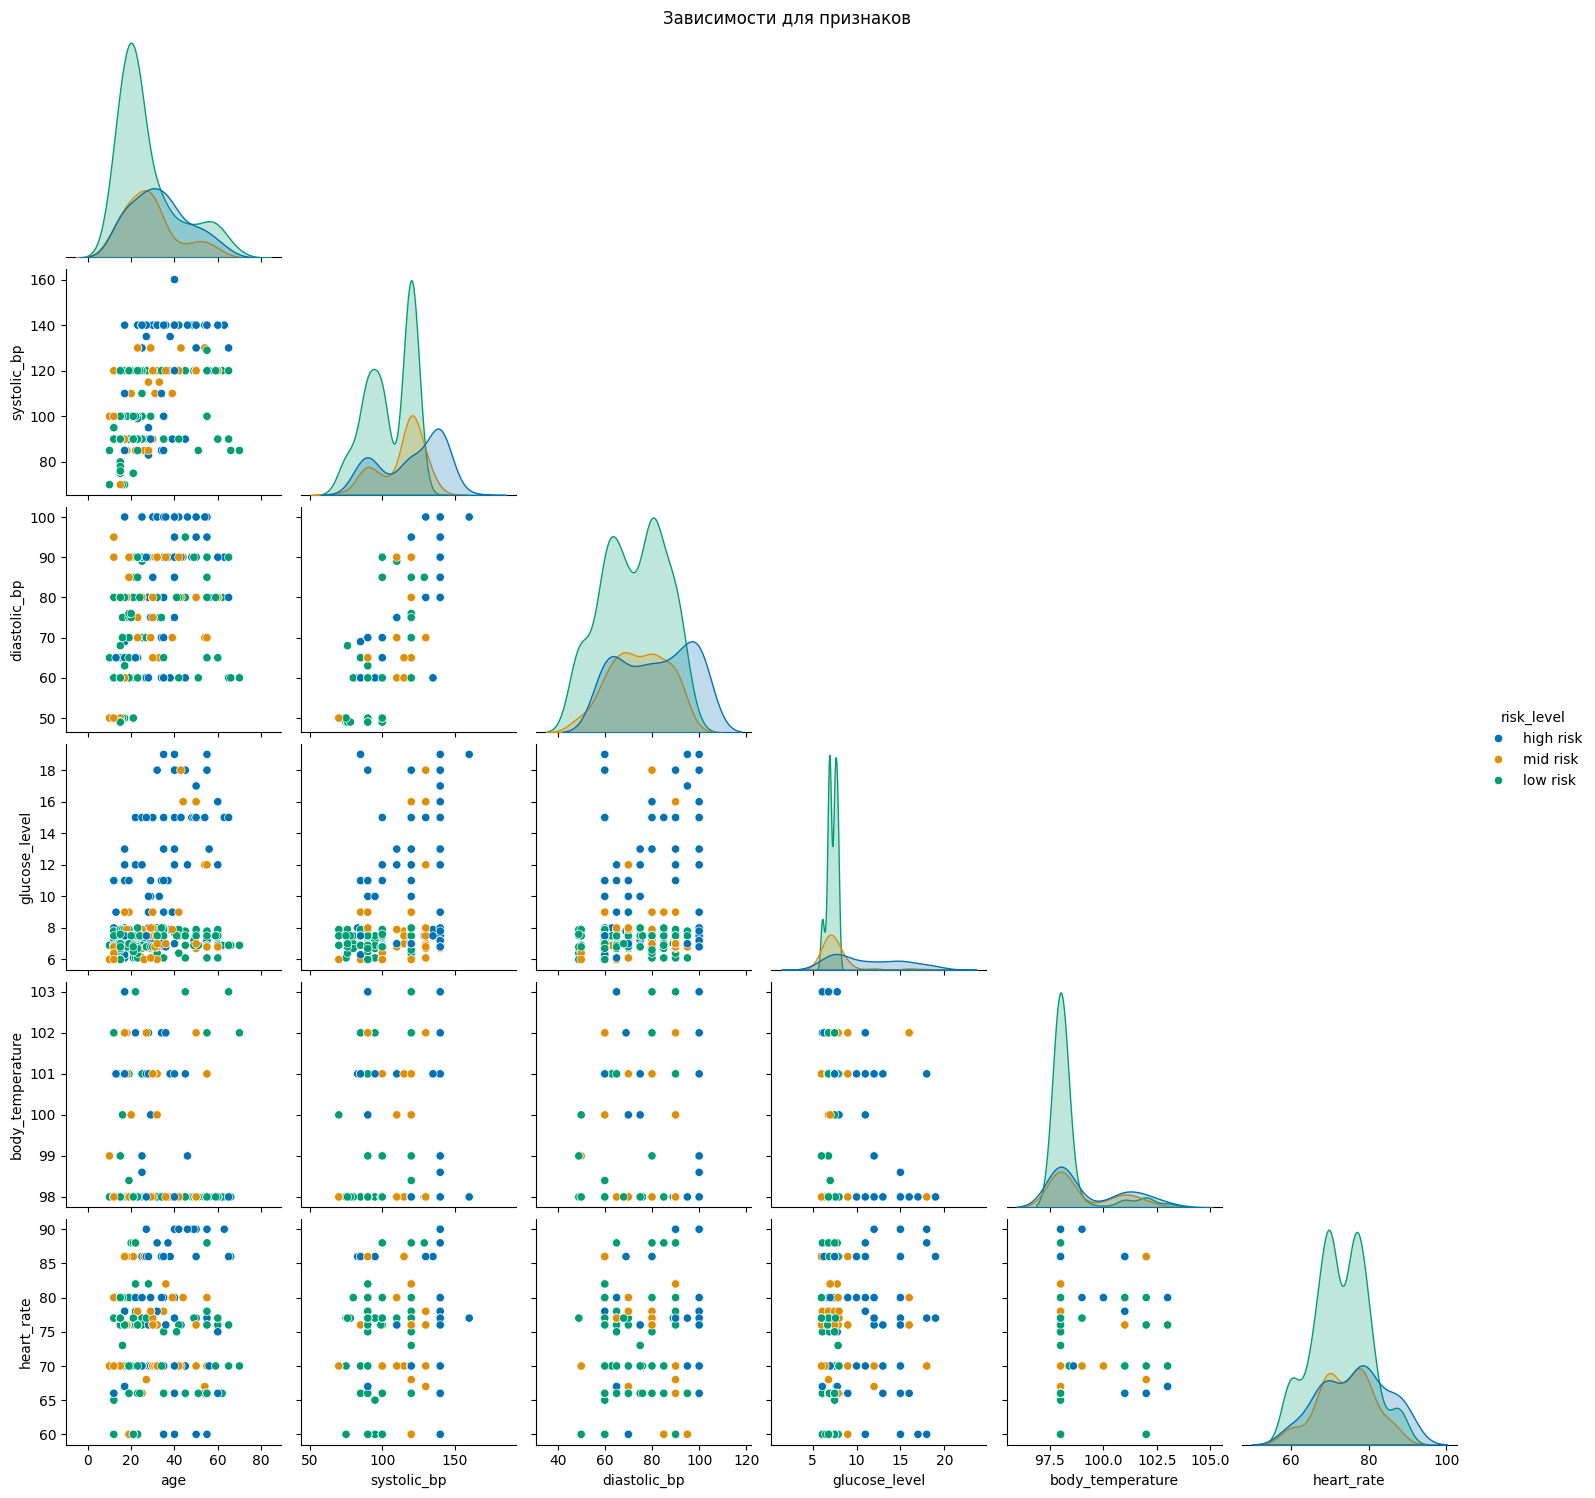

In [67]:
sns.pairplot(
    data=eda_data[num_features + [target]],
    hue=target,
    corner=True,
    palette="colorblind",
).fig.suptitle("Зависимости для признаков", y=1)
plt.show()

Дополнительных зависимостей не выявлено.

### Вывод по разделу "Корреляционный анализ данных"

В результате проведенной работы:
- среди количественных признаков не выявлено очевидной мультиколлениарности (оценен коэффициент корреляции Спирмена). При этом, два вида артериального давления довольно сильно связаны линейно. Целесообразно, при обучении линейных моделей исключить один из признаков или использовать их объедиение, например произведение;
- на основании матрицы корреляции PhiK выявлено, что ряд признаков оказывает существенное влияние на целевой признак, в частности, `systolic_bp` (0.79), `diastolic_bp` (0.56) и `glucose_level` (0,63). Соответственно, новый признак `pressure_group` оказывает аналогичное влияние. Странно выглядит низкое влияние возраста `age` и нового признака `age_group`. Возникают сомнения в качестве разметки данных. Тем более, что указанные признаки влияют на целевой признак аналогично температуре тела (`body_temperature`) и ЧСС (`heart_rate')..

Первоначальных признаков: 0 категориальных и 6 количественных.

Сгенерированных признаков: 2 категориальных и 0 количественных.

Итоговое количество признаков: 2 категориальных и 6 количественных.

## Сохранение очищенных данных

Для дальнейшего использования сохраним очищенные данные дафтафрейма `eda_data`

In [68]:
eda_data.reset_index(drop=True).to_csv("../data/clean_data.csv", index=False)